In [1]:
"""Data analysis and processing package imports"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
# import statsmodels.api as sm

import scipy.stats as stats
import scipy.cluster.vq as cluster

from scipy.signal import butter, filtfilt

from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

In [2]:
def csv_import(filename, header = True):
    """Imports csv file as a list and separates headers from data"""
    import csv
    file = open(filename)
    readfile = csv.reader(file)
    listfile = list(readfile)
    if header == True:
        headers = listfile[0]
        data = listfile[1:]
    else:
        data = listfile
    return headers, data

In [3]:
def findiff(p, dt):
    """Second-order accurate finite difference velocites and accelerations.

    Parameters:
    p = 1D array (size ntime) to take finite difference of
    dt = time step between measurements

    Returns:
    v = velocity
    a = acceleration

    Finite difference code from:
    See: https://en.wikipedia.org/wiki/Finite_difference_coefficient

    We are using 2nd order accurate central, forward, and backward finite
    differences.
    """

    n = len(p)
    v, a = np.zeros_like(p), np.zeros_like(p)

    # at the center
    for i in np.arange(1, n - 1):
        v[i] = .5 * p[i + 1] - .5 * p[i - 1]
        a[i] = p[i + 1] - 2 * p[i] + p[i - 1]

    # left boundary (forward difference)
    v[0] = -1.5 * p[0] + 2 * p[1] - .5 * p[2]
    a[0] = 2 * p[0] - 5 * p[1] + 4 * p[2] - p[3]

    # right boundary (backward differences)
    v[-1] = 1.5 * p[-1] - 2 * p[-2] + .5 * p[-3]
    a[-1] = 2 * p[-1] - 5 * p[-2] + 4 * p[-3] - p[-4]

    return v / dt, a / dt**2

In [4]:
def _sub3(a1, a2, a3):
    """Construct a 9x9 matrix given the upper, middle, and lower submatrices.
    """
    M = np.zeros((9, 9))
    M[0:3, 0:3] = a1
    M[3:6, 3:6] = a2
    M[6:9, 6:9] = a3
    return M

In [5]:
def _hx(x):
    """Measurement function. Constructs a 3 x 9 measurement matrix that
    maps from physical to measurement space. These are the same for us.
    """
    H = np.zeros((3, 9))
    H[0, 0] = 1
    H[1, 3] = 1
    H[2, 6] = 1
    return np.dot(H, x)

In [6]:
def _fx(x, dt):
    """State transition matrix from x(k) to x(k + 1). This is simply
    x1 = x0 + dt * v0 + .5 * a0^2
    v1 = v1 + dt * a0
    a1 = a0
    """
    f = np.array([[1, dt, .5 * dt**2],
                  [0, 1, dt],
                  [0, 0, 1]])
    F = _sub3(f, f, f)
    return np.dot(F, x)

In [7]:
def ukf(pr, fs, meas_noise):
    """Use an unscented Kalman filter to smooth the data and predict
    positions px, py, pz when we have missing data.

    Parameters:
    pr = (ntime x nmark x 3) raw data array in m
    fs = sampling rate
    meas_noise = measurement noise (from Qualisys), default=3

    Returns:
    out = dict that holds filtered position and calculated velocity
        and accleration. Keys are as follows:
        p, v, a: pos, vel, acc after RTS smoothing. These are the values
            to fill in the missing data gaps
        nans: (ntime x nmark) bool array that stores where we have bad values
    """

    ntrials, ntime, ncoor = pr.shape

    g = 9.810  # m/s^2
    dim_x = 9  # tracked variables px, vx, ax, py, vy, ay, pz, vz, az
    dim_z = 3  # measured variables px, py, pz
    dt = 1 / fs

    # state uncertainty matrix (measurement noise)
    R = meas_noise**2 * np.eye(dim_z)

    # process uncertainty matrix (effect of unmodeled behavior)
    sigx, sigy, sigz = .5 * g, .5 * g, .5 * g
    qx = Q_discrete_white_noise(3, dt=dt, var=sigx**2)
    qy = Q_discrete_white_noise(3, dt=dt, var=sigy**2)
    qz = Q_discrete_white_noise(3, dt=dt, var=sigz**2)
    Q = _sub3(qx, qy, qz)

    # uncertainty covariance matrix
    p0 = np.diag([1, 500, 2 * g])**2
    P = _sub3(p0, p0, p0)

    # store the data in 3D arrays
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()  # for after RTS smoothing
    pf0, vf0, af0 = pr.copy(), pr.copy(), pr.copy()  # for original pass
    nans = np.zeros((ntime, ntrials)).astype(np.int)

    # indices for ntime x 9 arrays to get pos, vel, and acc
    pos_idx, vel_idx, acc_idx = [0, 3, 6], [1, 4, 7], [2, 5, 8]

    for j in np.arange(ntrials):
        zs = pr[j, :].copy()

        # store the nan values
        idx = np.where(np.isnan(zs[:, 0]))[0]
        nans[idx, j] = 1

        # batch_filter needs a list, with a nan values as None
        zs = zs.tolist()
        for ii in idx:
            zs[ii] = None

        # initial conditions for the smoother
        x0 = np.zeros(9)
        x0[pos_idx] = zs[0]
        x0[vel_idx] = 0, 500, 1000  # guess v0, mm/s
        x0[acc_idx] = .1 * g, .1 * g, -.5 * g  # guess a0, mm/s^2

        # how to calculate the sigma points
        msp = MerweScaledSigmaPoints(n=dim_x, alpha=1e-3, beta=2, kappa=0)

        # setup the filter with our values
        kf = UKF(dim_x, dim_z, dt, _hx, _fx, msp)
        kf.x, kf.P, kf.R, kf.Q = x0, P, R, Q

        # filter 'forward'
        xs, covs = kf.batch_filter(zs)

        # apply RTS smoothing
        Ms, Ps, Ks = kf.rts_smoother(xs, covs, dts=dt)

        # get data out of the (ntime x 9) array
        pf0[j, :] = xs[:, pos_idx]
        vf0[j, :] = xs[:, vel_idx]
        af0[j, :] = xs[:, acc_idx]

        pf[j, :] = Ms[:, pos_idx]
        vf[j, :] = Ms[:, vel_idx]
        af[j, :] = Ms[:, acc_idx]

    # finally store everything in a dictionary
    out = {'p': pf, 'v': vf, 'a': af, 'pf0': pf0, 'vf0': vf0, 'af0': af0,
           'nans': nans, 'xs': xs, 'covs': covs, 'zs': zs, 'x0': x0}
    return out

In [8]:
def index_notnan(trial, frame):
    if not np.isnan(frame[trial,0]):
        return trial
    else:
        return index_notnan(trial+1, frame)

In [9]:
def fill_ukf_mg(pr, fs, meas_noise):
    """Fill-in missing data from the output of ukf. This only applies the
    filter to those arrays that are missing data.

    Parameters
    ----------
    pr : array, (ntime x nmark x 3)
        raw position data
    fs : float
        Sampling rate
    meas_noise : float
        Measurement noise in mm (output from Qualisys)

    Returns
    -------
    pfill : array, size (ntime x nmark)
        Array that holds the same (noisy) data as pr, except that
        nan locations have been filled with our predictions.
    nans : array, size (ntime x nmark)
        int array, 1's correspond to nan values
    pfill0 : array, size (ntime x nmark x 3)
        filled positions after the forward pass of the filter
        (excluding the RTS smoother).
    """

    ntrials, ntime, ncoord = pr.shape
    
    pfill = pr.copy()  
    pfill0 = pr.copy()
       
    nans = np.zeros((ntime, ntrials)).astype(np.int)
    for i in np.arange(ntrials):
        arr = np.copy(pr)[i, :, :]
        idx = np.where(np.isnan(arr[:, 0]))[0]
        nans[idx, i] = 1
        
        
        if len(idx) > 0:
            # convert to 3D array for ukf, since this function iterates
            # through all of the markers. now we have an ntime x 1 marker x
            # ncood array
            data = np.zeros((1, ntime, ncoord))
            data[0, :] = arr

            # perform the filtering
            out = ukf(data, fs, meas_noise)

            # take data from the smoothed array (output of ukf) and
            # copy over the naned values
            pfill[i, idx] = out['p'][0, idx]
            pfill0[i, idx] = out['pf0'][0, idx]

    return pfill, nans, pfill0

In [10]:
def but(pr, fs, fc, order=2, padlen=None):
    """Smooth with two passes of a Butterworth filter and calculate
    velocity and acceleration with finite differences.

    Parameters:
    pr = (ntime x nmark x 3) raw data array
    fs = sampling rate
    fc = Butterworth filter cutoff frequency (pick this from a
        residual analysis)
    order = filter order (default is 2)
    padlen = padding to use in filtfilt (default is None, so use
        ntime - 1 length of padding)

    Returns:
    out = dict that holds filtered position and calculated velocity
        and accleration; also return Wn, the fraction of the Nyquist
        used to construct the filter coefficients
    """

    ntime, nmark, ncoord = pr.shape

    fny = fs / 2  # Nyquist frequency
    Wn = fc / fny  # non-dimensional fraction of the Nyquist
    dt = 1 / fs  # measurement interval

    # get the filter coefficients
    butb, buta = butter(order, Wn)

    # padlen for filtfilt
    if padlen is None:
        padlen = ntime - 1

    # iterate through each marker and coordinate, smooth, and calculate
    # velocities and accelerations
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()
    for j in np.arange(nmark):
        for k in np.arange(ncoord):
            d = pr[:, j, k]
            p = filtfilt(butb, buta, d, padlen=padlen)
            v, a = findiff(p, dt)
            pf[:, j, k], vf[:, j, k], af[:, j, k] = p, v, a

    out = {'p': pf, 'v': vf, 'a': af, 'Wn': Wn}
    return out

In [11]:
def but_fcs(pr, fs, fcs, order=2, padlen=None):
    """Smooth with two passes of a Butterworth filter and calculate
    velocity and acceleration with finite differences. However, use
    difference cutoff frequencies for each marker and x, y, z
    time series.

    Parameters
    ----------
    pr = (ntime x nmark x ncoord) array
        raw data array
    fs = float
        sampling rate
    fcs = (nmark x ncoord) array
        Butterworth filter cutoff frequencies (pick this from the residual
        analysis)
    order = integer
        filter order (default is 2)
    padlen = integer or None
        padding to use in filtfilt (default is None, so use time - 1 length
        of padding)

    Returns
    -------
    out = dict
        Holds filtered position and calculated velocity
        and accleration; also return Wns, the fraction of the Nyquist
        used to construct the filter coefficients for each marker in
        the x, y, and z positions.
    """

    ntime, nmark, ncoord = pr.shape
    dt = 1 / fs  # measurement interval

    fny = fs / 2  # Nyquist frequency
    Wns = fcs / fny  # non-dimensional fraction of the Nyquist

    # padlen for filtfilt
    if padlen is None:
        padlen = ntime - 1

    # iterate through each marker and coordinate, smooth, and calculate
    # velocities and accelerations
    pf, vf, af = pr.copy(), pr.copy(), pr.copy()
    for j in np.arange(nmark):
        for k in np.arange(ncoord):
            # construct the filter
            butb, buta = butter(order, Wns[j, k])

            # select data and perform filtering
            d = pr[:, j, k]
            p = filtfilt(butb, buta, d, padlen=padlen)
            v, a = findiff(p, dt)
            pf[:, j, k], vf[:, j, k], af[:, j, k] = p, v, a

    out = {'p': pf, 'v': vf, 'a': af, 'Wns': Wns}
    return out

In [12]:
def residual_butter(pr, fs, order=2, df=.5, fmin=1, fmax=35):
    """Calculate RMS residuals to determine a proper cutoff frequency
    for a Butterworth filtering.

    Parameters:
    pr = (ntime x nmark x 3) raw data array
    fs = sampling frequency
    order = order filter to use, default is 2
    df = difference between frequencies
    fmin = min freq to try, default is 1
    fmax = max freq to try, default is 35

    Returns:
    R = residual array of (nfreq x nmark x 3) that has the RMS residual
        for a given marker is in X, Y, and Z directions.
    fcs = array of cutoff frequencies tried
    """

    ntime, nmark, ncoord = pr.shape

    # fcs = np.linspace(fmin, fmax, nfreq)
    fcs = np.arange(fmin, fmax + .01, df)
    nfreq = len(fcs)
    R = np.zeros((nfreq, nmark, 3))

    for i, fc in enumerate(fcs):
        out = but(pr, fs, fc, order)
        R[i] = np.sqrt(np.mean((pr - out['p'])**2, axis=0))

    return R, fcs

In [13]:
def opt_cutoff(R, fcs, rsq_cutoff=.95):
    """Find an 'optimum' cutoff frequency based on the residuals.

    Parameters:
    R = (nfreq x nmark x 3) array of residuals
    fcs = cutoff frequences used
    rsq_cutoff = coefficient of determination minimum that determines the
        frequency to perform the noise fit

    Returns:
    inter = (nmark x ncoord) array of y-intercepts in mm
    fcopt = (nmark x ncoord) array of 'optimum' cutoff frequencies
    rsq = (nmark x ncoord) array of R^2 values
    flinreg = (2 x nmark x ncoord) array of the fmin, fmax values to
        construct the linear regression to get the cutoff frequency

    Notes:
    This function fits a linear line to the tail of the residual, finds
    the intercept (a residual) and the corresponding cutoff frequency
    this residual corresponds to. This is a 'rough' find, that is, it
    finds the nearest freqeuncy in the array of provided requencies and does
    not do root finding of an interpolation function, etc.

    http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    """
    from scipy.stats import linregress
    from scipy.optimize import newton
    from scipy.interpolate import interp1d

    nfreq, nmark, ncoord = R.shape

    inter = np.zeros((nmark, ncoord))
    fcopt = np.zeros((nmark, ncoord))
    rsq = np.zeros((nmark, ncoord))
    flinreg = np.zeros((2, nmark, ncoord))

    for j in np.arange(nmark):
        for k in np.arange(3):
            # res = R[idx, j, k]
            res = R[:, j, k]

            # iterative find the min freq to perform interpolation
            # step backwards through the arratriay, until rsq drops to rsq_cutoff
#            ixcut = np.inf  # if don't get into if, this will throw an error
            for mm in np.arange(nfreq - 2, 0, -1):
                slope, intercept, r_value, p_value, std_err = \
                    linregress(fcs[mm:], res[mm:])
                # print r_value**2
                if r_value**2 < rsq_cutoff:
                    ixcut = mm + 1
                    break

            # once we go under rsq_cutoff, use the previous value
            slope, intercept, r_value, p_value, std_err = \
                linregress(fcs[ixcut:], res[ixcut:])

            # optimize the cutoff frequency
            def tozero(freq_guess):
                return resid_interp(freq_guess) - intercept

            # interpolation function of the residuals
            resid_interp = interp1d(fcs, res)
            fopt_guess = fcs[np.argmin(np.abs(res - intercept))]
            fopt = newton(tozero, fopt_guess)

            # store the values
            inter[j, k] = intercept
            fcopt[j, k] = fopt
            rsq[j, k] = r_value**2
            flinreg[:, j, k] = fcs[ixcut], fcs[-1]

    return inter, fcopt, rsq, flinreg

In [14]:
def straighten_traj(pf_I, vf_I, af_I):

    ntime = len(pf_I)
#    as_straighten = []
    
    # straightened CoM position
    p0 = pf_I[0]
#    pf_S = np.array([x - p0 for x in pf_I])
    pf_S = pf_I.copy() - p0

    # iterate through the points a find the successive rotation angles and
    # straighten the CoM trajectory
    mus = np.zeros(ntime)
    Rmus = np.zeros((ntime, 3, 3))
    for i in np.arange(ntime):
#        Set this point
        if i == 0:
            prev = pf_S[i]
            continue
        else:
            uu = pf_S[i] - prev
            
            mu = np.arctan2(uu[0], uu[1])  # -tan^-1(px / py)
            Rmu = np.array([[np.cos(mu), -np.sin(mu), 0],
                        [np.sin(mu),  np.cos(mu), 0],
                        [0, 0, 1]])

            mus[i] = mu
            Rmus[i] = Rmu

        # apply the rotation to each point along the spline
            for ii in np.arange(i, ntime):
                pf_S[ii] = pf_S[ii] - prev
                pf_S[ii] = np.dot(Rmu, pf_S[ii])
                pf_S[ii] = pf_S[ii] + prev
            
            prev = pf_S[i]

    # move back to start of inertial CoM position
    pf_S = pf_S + p0

    # now rotate the non-position variables

    # use the yaw angle to rotate points and velocities
    yaw = np.arctan2(-vf_I[:, 0], vf_I[:, 1])  # yaw angle
    yaw = np.unwrap(yaw)

    # rotation matrix about yaw axis
    C_I2S = np.zeros((ntime, 3, 3))

    vf_S = np.zeros_like(vf_I)
    af_S = np.zeros_like(af_I)
    for i in np.arange(ntime):
        # rotation matrix
        C_I2S[i] = np.array([[np.cos(yaw[i]), np.sin(yaw[i]), 0],
                             [-np.sin(yaw[i]),  np.cos(yaw[i]), 0],
                             [0, 0, 1]])

        # rotate them
        vf_S[i] = np.dot(C_I2S[i], vf_I[i].T).T
        af_S[i] = np.dot(C_I2S[i], af_I[i].T).T

    # glide angle based on straighted trajectory velcity down from horizontal
    # this ensures when rotated to this direction, only velocity in yhat
    gamma = -np.arctan2(vf_S[:, 2], vf_S[:, 1])  # glide angle

    return pf_S, vf_S, af_S, yaw, gamma, C_I2S


In [15]:
"""Key constants related to data collection"""
fs = 29.97
dt = 1/fs
meas_noise = 0.04

In [16]:
"""Import and create frame indices from Digitization catalog"""
filename = 'GoPro_Digi_Catalog.csv'
idx_data = pd.read_csv(filename)
idx_data.columns = idx_data.columns.str.strip().str.replace(' ', '_').str.lower()
idx_data = idx_data.drop(0, 0).drop(['number_of_gp_landings', 'number_of_matches'], 1)
nlandings = idx_data.index

bad_digi = idx_data[idx_data['usable_landings'] != 1]
idx_data = idx_data.drop(bad_digi.index, axis=0)
ground_idx = idx_data[idx_data['notes'].str.contains(r'[Gg]round') == True]
idx_data = idx_data.drop(ground_idx.index, axis=0)

ntrials, columns = idx_data.shape
new_index = np.linspace(0, ntrials, ntrials, False)
new_index = np.array(new_index + 1)
new_idx = new_index.astype(int)

idx_data.set_index(new_idx, inplace=True)
idx_data['date'] = idx_data['date'].astype(str).str.strip('.0')
ground_idx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 64 to 171
Data columns (total 11 columns):
date                      2 non-null float64
gopro_vid_id              2 non-null object
usable_landings           2 non-null float64
sex                       2 non-null object
start_frame               2 non-null float64
impact_frame              2 non-null float64
end_frame                 2 non-null float64
rsv_match                 2 non-null float64
rsv_vid_id                0 non-null object
number_of_conspecifics    0 non-null float64
notes                     2 non-null object
dtypes: float64(7), object(4)
memory usage: 192.0+ bytes


In [17]:
"""Import all landing vids"""
data_dict = {}
for i in np.arange(ntrials):
    date = idx_data['date'].iat[i]
    vid_id = idx_data['gopro_vid_id'].iat[i]
    filename = str('GoPro_Landing_dataset/' + date + '-digi-GP.Landing.' + vid_id + '-xyzpts.csv')
    
    try:
        axes, data = csv_import(filename)
    except FileNotFoundError:
        print(filename)
    
    data = np.array(data).astype('float64')
    data_dict[i] = {'raw':data}

In [18]:
"""Clip, interpolate, filter, and straighten each landing - save all landing data to a data_dict"""
for i in np.arange(ntrials):
#     print(i, idx_data['gopro_vid_id'].iloc[i], idx_data['start_frame'].iloc[i], idx_data['impact_frame'].iloc[i], idx_data['end_frame'].iloc[i])
    data = data_dict[i]['raw'].copy()
    stt = int(idx_data['start_frame'].iloc[i] - 1)
    end = int(idx_data['end_frame'].iloc[i])
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    clip_data = np.asarray(data[stt:end, :])
    data_dict[i]['clipped'] = clip_data
    
    ntime, ncoord = clip_data.shape
    
    nans= np.zeros((ntime, ntrials)).astype(np.int)
    
    pfill = clip_data.copy()
    pfill0 = clip_data.copy()
    
    arr = np.copy(clip_data)[:, :]
    idx = np.where(np.isnan(arr[:, 0]))[0]
    nans[idx, i] = 1
    
    if len(idx) > 0:
        data = np.zeros((1, ntime, ncoord))
        data[0, :] = arr
        
        out = ukf(data, fs, meas_noise)
        
        pfill[idx] = out['p'][0, idx]
        pfill0[idx] = out['pf0'][0, idx]

    data_dict[i]['filtered'] = pfill
    
    landing_pos = pfill[imp, :]
    pfill -= landing_pos
    if i > 23:
        pfill[:,2] *= -1
    
    data_dict[i]['aligned_imp'] = pfill
    
    pr_I = pfill
    
    resid_array = np.zeros((ntime, 1, 3,))
    resid_array[:, 0] = pr_I
    resid, fcs = residual_butter(resid_array, fs, df=.1, fmin=0.1, fmax=10)
    inter, fcopt, rsq, flinreg = opt_cutoff(resid, fcs, rsq_cutoff=.95)
    
    out = but_fcs(resid_array, fs, fcopt)
       
    data_dict[i]['pf_I'] = out['p'][:,0]
    data_dict[i]['vf_I'] = out['v'][:,0]
    data_dict[i]['af_I'] = out['a'][:,0]
    data_dict[i]['Wns'] = out['Wns'][:,0]

    data_dict[i]['resid'] = resid[:, 0]
    data_dict[i]['fcs'] = fcs
    data_dict[i]['inter'] = inter.flatten()
    data_dict[i]['fcopt'] = fcopt.flatten()
    data_dict[i]['rsq'] = rsq.flatten()
    data_dict[i]['flinreg'] = flinreg[:, 0]
    
for i in np.arange(ntrials):
    pf_I, vf_I, af_I = data_dict[i]['pf_I'], data_dict[i]['vf_I'], data_dict[i]['af_I']
    out = straighten_traj(pf_I, vf_I, af_I)
    pf_S, vf_S, af_S, yaw, gamma, C_I2S = out
    
    data_dict[i]['pf_S'] = pf_S
    data_dict[i]['vf_S'] = vf_S
    data_dict[i]['af_S'] = af_S
    data_dict[i]['yaw'] = yaw
    data_dict[i]['gamma'] = gamma
    data_dict[i]['C_I2S'] = C_I2S

In [19]:
"""Additional packages and settings for analyses and figure generation"""
import seaborn as sns

from matplotlib import rcParams as rc
from pandas.plotting import scatter_matrix
from mpl_toolkits import mplot3d

bmap = sns.diverging_palette(255, 133, l=60, n=7, center='dark')

rc = {'pdf.fonttype':42, 'ps.fonttype':42, 'mathtext.fontset':'cm'}
sns.set('paper', 'ticks', font='Calibri', palette='deep',
        font_scale=1.5, color_codes=True, rc=rc)



%matplotlib inline

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


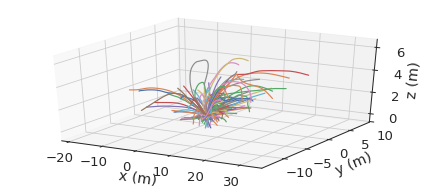

In [20]:
"""Generate 3D plot of all landing trajectories"""
# with sns.color_palette('colorblind'):
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')


for i in np.arange(ntrials):
    pos = data_dict[i]['pf_I'].copy()
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]

    plt.plot(x,y,z)

ax.set_xlabel('x (m)', labelpad=7)
ax.set_ylabel('y (m)', labelpad=7)
ax.set_zlabel('z (m)', labelpad=-1)
# ax.set_title('Flight trajectories in 3D')
ax.set_yticks(np.arange(-10, 11, 5))
ax.set_zticks(np.arange(0, 8, 2))
ax.axis('scaled')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('3D-177-LandingTrajectories', dpi=300)

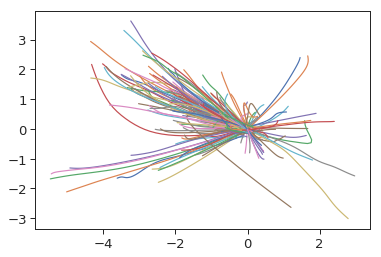

In [21]:
fig, ax = plt.subplots()
for i in np.arange(ntrials):
    pos = data_dict[i]['pf_I'].copy()
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    x = pos[imp:,0]
    y = pos[imp:,1]
    
    plt.plot(x,y)
plt.show()

In [22]:
"""Find point at which initial descent occurs; best guess for true beginning of landing behavior"""
x_int = []
idx = np.arange(ntrials) + 1
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    pf = data_dict[i]['pf_S'].copy()
    s = pd.DataFrame(pf[:imp,2])
    imp_s = pf[imp,2]
    rows, cols = s.shape
    s = s - imp_s
    time = round(rows*0.80)
    z_dot = s[:time].diff().rolling(1).sum().dropna().abs()

    z_dot_min = z_dot.min()
    z_min = z_dot[z_dot == z_dot_min].dropna()
    x_int.append(z_min.index.values)

int_df = pd.DataFrame(x_int, index=idx)

idx_data['descent_start'] = int_df

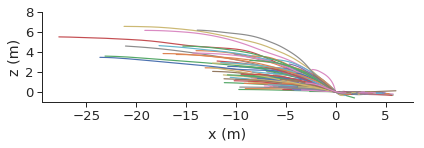

In [23]:
"""Generate a 2D plot of all landing trajectories"""
# with sns.color_palette('colorblind'):
fig, ax = plt.subplots()
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    stt = int(idx_data['descent_start'].iloc[i])

    pf = data_dict[i]['pf_S'].copy()
#     glide_angle = np.rad2deg(pf)

    x = pf[:,1]
    y = pf[:,2]
    imp_x = pf[imp,1]
    imp_y = pf[imp,2]

    x = x - imp_x
    y = y - imp_y
    n = len(x[:])
    t = np.linspace(0,n,n,False)
    t = t/fs
    t = t-t[imp]

#     plt.plot(t, y)
    plt.plot(x[stt:],y[stt:])

ax.axis('scaled')    
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
# ax.set_title('Flight trajectories in 2D')
plt.yticks(np.arange(0, 10, 2.0))

sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("2D-177-LandingTrajectories_descent_only", dpi=300)

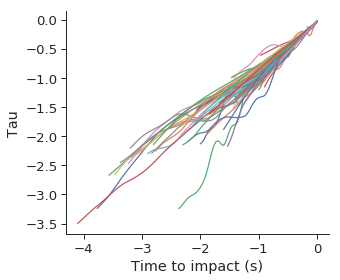

In [24]:
"""Calculation of tau, plotting, and pearson coefficient analysis to find tau_dot"""
tau_dot = []
tau_pvalues = []
pear_coef = []
tau_r2values = []

fig, ax = plt.subplots()
for i in np.arange(ntrials):        
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    stt = int(idx_data['descent_start'].iloc[i])
    
    pos = data_dict[i]['pf_S'].copy()
    vel = data_dict[i]['vf_S'].copy()

    x = pos[:imp,1]
    x =abs(x - pos[imp, 1])
    x_dot = vel[:imp,1]

    tau = (np.divide(x, x_dot))*-1
    data_dict[i]['tau'] = tau

    n = len(x)
    t = np.linspace(0,n,n,False)
    t = t/fs
    t = t-np.max(t)

    plt.plot(t[stt:], tau[stt:])

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t[stt:], tau[stt:])
    tau_dot.append(slope)
    coef, p_value = scipy.stats.pearsonr(t[stt:], tau[stt:])
    tau_pvalues.append(p_value)
    pear_coef.append(coef)
    r2 = r_value**2
    tau_r2values.append(r2)


ax.set_ylabel('Tau')
ax.set_xlabel('Time to impact (s)')
ax.axis('scaled')
# ax.set_xlim(-0.6, 0)
# ax.set_ylim(-0.6, 0)
# ax.set_yticks(np.arange(-0.6, 0.1, 0.2))
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig("Final-TauTrajectories_v01", dpi=300)

idx = np.arange(ntrials) + 1
 
idx_data['tau_dot'] = pd.Series(tau_dot, index=idx)
idx_data['pearson_coef'] = pd.Series(pear_coef, index=idx)
idx_data['tau_pvalues'] = pd.Series(tau_pvalues, index=idx)
idx_data['tau_r2values'] = pd.Series(tau_r2values, index=idx)

In [25]:
"""Find distance traveled after impact"""
dist = []
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    pos = data_dict[i]['pf_S'].copy()
    pos = pos[imp:, :]
    n = len(pos) - 1
    
    r_all = []
    for ii in np.arange(n):
        ith = int(ii)
        jth = int(ii+1)
        
        xi = pos[ith, 1]
        zi = pos[ith, 2]
        
        xj = pos[jth, 1]
        zj = pos[jth, 2]
        
        r = np.sqrt((xi-xj)**2 + (zi-zj)**2)
        r_all.append(r)
    dist.append(np.sum(r_all))

idx_data['distance_after_impact'] = pd.Series(dist, index=idx)

In [26]:
"""Calculate impact_speed, impact_angle, and mean_approach_angle"""
impact_speed = []
impact_angle = []
mean_angle = []
for i in np.arange(ntrials):
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    u = data_dict[i]['vf_S'].copy()
    imp_speed = np.hypot(u[imp, 1], u[imp, 2])
    impact_speed.append(imp_speed)
    
    g = data_dict[i]['gamma'].copy()
    glide_angle = np.rad2deg(g)
    imp_angle = glide_angle[imp]
    impact_angle.append(imp_angle)
    
    angle_dot = np.mean(glide_angle[:imp])
    mean_angle.append(angle_dot)

idx_data['impact_speed'] = pd.Series(impact_speed, index=idx)
idx_data['impact_angle'] = pd.Series(impact_angle, index=idx)
idx_data['mean_angle'] = pd.Series(mean_angle, index=idx)

In [27]:
"""Calculate landing vector angle"""
impact_direction = []
for i in np.arange(ntrials):
    vel = data_dict[i]['vf_I'].copy()
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])

    x = vel[imp,0]
    y = vel[imp,1]
    
    angle = np.degrees(np.arctan2(y,x))
    
    impact_direction.append(angle)
    
idx_data['direction_angle'] = pd.Series(impact_direction, index=idx)
    
idx_data[['direction_angle']].describe()

,direction_angle
count,177.000000
mean,68.525433
std,122.078005
min,-178.934276
25%,-22.488546
50%,143.938968
75%,157.270305
max,179.476089


In [28]:
"""Find max angle of end of skim from point of impact"""
arc_angle = []
end_angle = []
for i in np.arange(ntrials):
    pos = data_dict[i]['pf_I'].copy()
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    end = int(idx_data['end_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    
    xy_i = pos[imp,:2]
    xy_j = pos[end,:2]
    
    xy = np.subtract(xy_j, xy_i)
    
    angle = np.degrees(np.arctan2(xy[1], xy[0]))
    end_angle.append(angle)
    
    dir_angle = idx_data['direction_angle'].iloc[i]
    if dir_angle < 0 and angle < 0:
        angle_diff = np.subtract(angle, dir_angle)
    elif dir_angle > 0 and angle > 0:
        angle_diff = np.subtract(angle, dir_angle)
    else:
        angle_diff = np.add(angle, dir_angle)
    
    arc_angle.append(np.abs(angle_diff))

idx_data['end_pos_angle'] = pd.Series(end_angle, index=idx)
idx_data['skim_arc_angle'] = pd.Series(arc_angle, index=idx)
idx_data['skim_arc_angle'].describe()
    

count    177.000000
mean       8.490905
std       11.938140
min        0.027067
25%        2.328900
50%        4.920219
75%        9.383726
max       90.778940
Name: skim_arc_angle, dtype: float64

In [29]:
idx_data.columns

Index(['date', 'gopro_vid_id', 'usable_landings', 'sex', 'start_frame',
       'impact_frame', 'end_frame', 'rsv_match', 'rsv_vid_id',
       'number_of_conspecifics', 'notes', 'descent_start', 'tau_dot',
       'pearson_coef', 'tau_pvalues', 'tau_r2values', 'distance_after_impact',
       'impact_speed', 'impact_angle', 'mean_angle', 'direction_angle',
       'end_pos_angle', 'skim_arc_angle'],
      dtype='object')

In [30]:
idx_data[['date','gopro_vid_id','direction_angle', 'end_pos_angle', 'skim_arc_angle', 'distance_after_impact']].where(idx_data['skim_arc_angle'] > 45).dropna()

,date,gopro_vid_id,direction_angle,end_pos_angle,skim_arc_angle,distance_after_impact
2,20170228,A01f,71.944914,0.000000,71.944914,0.000000
96,20181108,A01v,156.125368,-65.346428,90.778940,6.040371
172,20190214,A14a,113.182706,58.151540,55.031166,1.551370


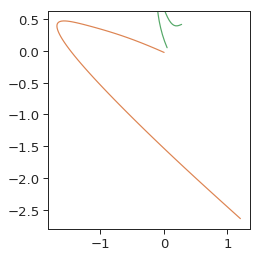

In [36]:
test = [1, 95, 171]
fig, ax = plt.subplots()
for i in test:
    pos = data_dict[i]['pf_I'].copy()
    imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
    x = pos[imp:,0]
    y = pos[imp:,1]
    
    ax.axis('scaled')
    plt.plot(x,y)
plt.show()

(-1.0526820767279645,
 19.65048025491582,
 -0.8810785228101519,
 4.364580963981272)

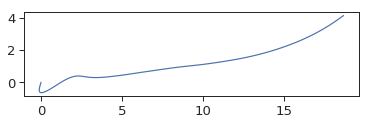

In [59]:
i = 1
fig, ax = plt.subplots()
pos = data_dict[i]['pf_I'].copy()
imp = int(idx_data['impact_frame'].iloc[i] - idx_data['start_frame'].iloc[i])
x = pos[:,0]
y = pos[:,1]

plt.plot(x,y)
ax.axis('scaled')

In [32]:
idx_data.loc[96]

date                         20181108
gopro_vid_id                     A01v
usable_landings                     1
sex                            Female
start_frame                      1361
impact_frame                     1419
end_frame                        1483
rsv_match                           0
rsv_vid_id                        NaN
number_of_conspecifics              2
notes                             NaN
descent_start                      27
tau_dot                       1.02069
pearson_coef                  0.99897
tau_pvalues               1.63739e-40
tau_r2values                 0.997941
distance_after_impact         6.04037
impact_speed                  4.24022
impact_angle                  10.3773
mean_angle                  0.0962635
direction_angle               156.125
end_pos_angle                -65.3464
skim_arc_angle                90.7789
Name: 96, dtype: object

In [33]:
# idx_data.to_csv('CompositeData_Export.csv')